In [1]:
import iris
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
#    ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
#              'vdatum_gulf_of_maine/adcirc54_38_orig.nc')
    ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
              'vdatum_fl_sab/adcirc54.nc')
    cubes = iris.load_raw(ncfile)

print(cubes)

0: longitude / (degrees)               (-- : 353718)
1: Tide Constituent / (no_unit)        (-- : 38; -- : 64)
2: Horizontal Element Incidence List / (1) (-- : 622367; -- : 3)
3: Northward Water Velocity Phase / (unknown) (Depth-Averaged Output in the Vertical: 1; -- : 353718; -- : 38)
4: depth / (meters)                    (-- : 353718)
5: latitude / (degrees)                (-- : 353718)
6: Eastward Water Velocity Phase / (unknown) (Depth-Averaged Output in the Vertical: 1; -- : 353718; -- : 38)
7: Northward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 353718; -- : 38)
8: Tide Frequency / (radians/second)   (-- : 38)
9: Eastward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 353718; -- : 38)


In [2]:
units = dict({'knots': 1.9438, 'm/s': 1.0})
consts = ['STEADY', 'M2', 'S2', 'N2', 'K1', 'O1', 'P1', 'M4', 'M6']

bbox = [-70.7234, -70.4532, 41.4258, 41.5643]  # Vineyard sound 2.
bbox = [-85.25, -84.75, 29.58, 29.83]  # Apalachicola Bay
halo = 0.1
ax2 = [bbox[0] - halo * (bbox[1] - bbox[0]),
       bbox[1] + halo * (bbox[1] - bbox[0]),
       bbox[2] - halo * (bbox[3] - bbox[2]),
       bbox[3] + halo * (bbox[3] - bbox[2])]

In [3]:
import pytz
from datetime import datetime
from pandas import date_range


start = datetime.strptime('18-Sep-2015 05:00',
                          '%d-%b-%Y %H:%M').replace(tzinfo=pytz.utc)
stop = datetime.strptime('19-Sep-2015 05:00',  # '18-Sep-2015 18:00'
                         '%d-%b-%Y %H:%M').replace(tzinfo=pytz.utc)

dt = 1.0  # Hours.

glocals = date_range(start, stop, freq='1H').to_pydatetime()

ntimes = len(glocals)

In [4]:
def parse_string(name):
    return ''.join(name.tolist()).strip()


names = []
data = cubes.extract_strict('Tide Constituent').data
for name in data:
    names.append(parse_string(name))

In [5]:
from scipy.spatial import Delaunay

depth = cubes.extract_strict('depth').data
latf = cubes.extract_strict('latitude').data
lonf = cubes.extract_strict('longitude').data
frequency = cubes.extract_strict('Tide Frequency').data

# Not sure why this is not working.
# trif = cubes.extract_strict('Horizontal Element Incidence List').data
trif = Delaunay(zip(lonf, latf)).vertices

In [6]:
# Find indices in box.
import numpy as np


inbox = np.logical_and(np.logical_and(lonf >= ax2[0],
                                      lonf <= ax2[1]),
                       np.logical_and(latf >= ax2[2],
                                      latf <= ax2[3]))

lon = lonf[inbox]
lat = latf[inbox]

In [7]:
import os.path
from scipy.io import loadmat

mat = os.path.join('..', 't_tide_v1.3beta', 't_constituents.mat')
con_info = loadmat(mat, squeeze_me=True)
con_info = con_info['const']  # I am ignore shallow water and sat constants!

In [8]:
from utide import _ut_constants_fname
from utide.utilities import loadmatbunch

con_info = loadmatbunch(_ut_constants_fname)['const']

In [9]:
# Find the indices of the tidal constituents.

k = 0
ind_nc, ind_ttide = [], []

const_name = [e.strip() for e in con_info['name'].tolist()]

for name in consts:
    try:
        if name == 'STEADY':
            indx = const_name.index('Z0')
        else:
            indx = const_name.index(name)
        k += 1
        ind_ttide.append(indx)
        ind_nc.append(names.index(name))
    except ValueError:
        pass  # `const` not found.

In [10]:
ua = cubes.extract_strict('Eastward Water Velocity Amplitude')
up = cubes.extract_strict('Eastward Water Velocity Phase')
va = cubes.extract_strict('Northward Water Velocity Amplitude')
vp = cubes.extract_strict('Northward Water Velocity Phase')

In [11]:
ua.shape

(1, 353718, 38)

In [12]:
uamp = ua.data[0, inbox, :][:, ind_nc]
vamp = va.data[0, inbox, :][:, ind_nc]
upha = up.data[0, inbox, :][:, ind_nc]
vpha = vp.data[0, inbox, :][:, ind_nc]

In [13]:
freq_nc = frequency[ind_nc]

In [14]:
print uamp.shape
print freq_nc.shape

(3215L, 9L)
(9L,)


In [15]:
freq_ttide = con_info['freq'][ind_ttide]

In [16]:
t_tide_names = np.array(const_name)[ind_ttide]

In [17]:
omega_ttide = 2*np.pi * freq_ttide  # Convert from radians/s to radians/hour.

omega = freq_nc * 3600

rllat = 55  # Reference latitude for 3rd order satellites (degrees) (55 is fine always)

In [18]:
from matplotlib.dates import date2num

# Convert to Matlab datenum.
# (Soon UTide will take python datetime objects.)
jd_start = date2num(start) + 366.1667

In [19]:
from utide.harmonics import FUV


# NB: I am not a 100% sure if this is identical to what we had with t_tide.
# ngflgs -> [NodsatLint NodsatNone GwchLint GwchNone]
v, u, f = FUV(t=np.array([jd_start]), tref=np.array([0]),
              lind=np.array([ind_ttide]),
              lat=55, ngflgs=[0, 0, 0, 0])

In [20]:
# Convert phase in radians.
v, u, f = map(np.squeeze, (v, u, f))
v = v * 2 * np.pi
u = u * 2 * np.pi

thours = np.array([d.total_seconds() for d in
                   (glocals - glocals[0])]) / 60 / 60.


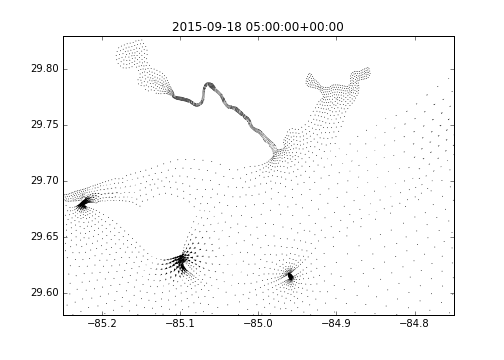

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib.animation import FuncAnimation

def update_figure(k):
    global ax, fig
    ax.cla()
    
    U = (f * uamp * np.cos(v + thours[k] * omega + u - upha * np.pi/180)).sum(axis=1)
    V = (f * vamp * np.cos(v + thours[k] * omega + u - vpha * np.pi/180)).sum(axis=1)
    
    w = units['knots'] * (U + 1j * V)
    
    wf = np.NaN * np.ones_like(lonf, dtype=w.dtype)
    wf[inbox] = w

    # FIXME: Cannot use masked arrays and tricontour!
    # wf = ma.masked_invalid(wf)
    # cs = ax.tricontour(lonf, latf, trif, np.abs(wf).filled(fill_value=0))
    # fig.colorbar(cs)
    q = ax.quiver(lon, lat, U, V, scale=40)
    ax.axis(bbox)  # Vineyard sound 2.
    ax.set_title('{}'.format(glocals[k]))

fig, ax = plt.subplots(figsize=(7, 5))
FuncAnimation(fig, update_figure, interval=100, frames=ntimes)

[-85.25, -84.75, 29.58, 29.83]

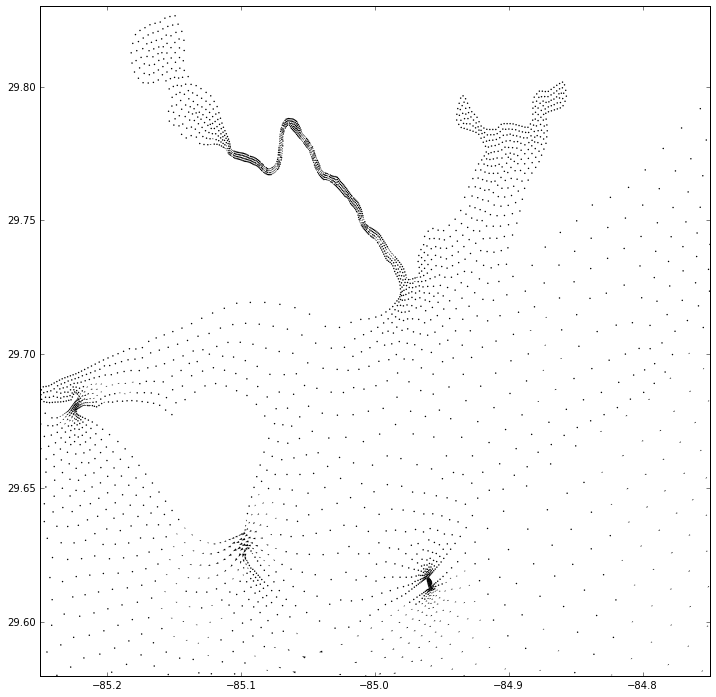

In [22]:
plt.figure(figsize=(12,12))
U = (f * uamp * np.cos(v + thours[k] * omega + u - upha * np.pi/180)).sum(axis=1)
V = (f * vamp * np.cos(v + thours[k] * omega + u - vpha * np.pi/180)).sum(axis=1)

w = units['knots'] * (U + 1j * V)

wf = np.NaN * np.ones_like(lonf, dtype=w.dtype)
wf[inbox] = w

# FIXME: Cannot use masked arrays and tricontour!
# wf = ma.masked_invalid(wf)
# cs = ax.tricontour(lonf, latf, trif, np.abs(wf).filled(fill_value=0))
# fig.colorbar(cs)
q = plt.quiver(lon, lat, U, V, scale=40)
plt.axis(bbox)  # Vineyard sound 2.
#q.set_title('{}'.format(glocals[k]))

In [23]:
iris.__version__

'1.8.1'